## First attempt to play with xopt


## Load in a BELLA specific config file
read in a yaml file which has the control variable information and the objective variable information

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

import yaml
import pandas as pd
import numpy as np

# Axicon Horizontal vertical looking at minimizing STD 
# yamlfile="AxiconHorizontalVertical.yaml"
# evaluator_str = "-abs(np.std(outs))"
# TestPoints_dict = {"AxiconHorizontal":0.5,"AxiconVertical":0.5}
# InitialPoints_dict = {"AxiconHorizontal":[0.85,0.1],"AxiconVertical":[0.85,0.1]}
#tolerance=0.001

#hpd focal scan
yamlfile="PWfocusLpMode.yaml"
evaluator_str = "np.median(outs)"
TestPoints_dict = {"Position":0.5}
InitialPoints_dict = {"Position":[0.7,0.3]}
tolerance=0.01

# yamlfile="AxiconHorizontalVertical.yaml"
# evaluator_str = "-abs(np.std(outs))"
# TestPoints_dict = {"AxiconHorizontal":0.5,"AxiconVertical":0.5}
# InitialPoints_dict = {"AxiconHorizontal":[0.85,0.1],"AxiconVertical":[0.85,0.1]}
#tolerance=0.01


# this one is good for aligning to a crosshair
#    return {'f': -abs(np.median(outs)-672)}
#This is for minimizing fluctuation of the data
#    return {'f': eval(evaluator_str)}

#define a "yaml file" with no entries for variables. These will be filled in used the "bella_config" yamml file
YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: upper_confidence_bound
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: []

evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
        {}
    objectives: {f: "MAXIMIZE"}

"""
yaml_output = yaml.safe_load(YAML)

with open(yamlfile, "r") as stream:
    try:
        bella_config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
normalize_ranges=True

ranges=[]
obj_tags=[]

#parse the config file to create a dict with the variables in proper format for xopt
cv_tags=dict(bella_config['control_variables'])
for cv_tag, cv_config in cv_tags.items():
    if cv_config['set']:
        ranges.append(cv_config['range'])
        range_offset=[0,cv_config['range'][1]-cv_config['range'][0]]
        range_norm=[0,1]
        print(range_offset)
        if normalize_ranges:
            yaml_output['vocs']['variables'][cv_tag]=[0,1]
            yaml_output['generator']['acq']['proximal_lengthscales'].append(cv_config['proximal_lengthscale']/range_offset[1])
        else:
            yaml_output['vocs']['variables'][cv_tag]=cv_config['range']
    if cv_config['objective']:
        obj_tags.append(cv_tag)
        
        
# for i in obj_tags:
#     yaml_output['vocs']['objectives'][i]=bella_config['objective_variables'][i]['method']
    
print(yaml_output)

#until I figure out the above, we will need to initialize the requisite Xopt objects
#individually

# vocs = VOCS(
#     variables=yaml_output['vocs']['variables'],
#     objectives=yaml_output['vocs']['objectives'],
# )

# print(vocs)
print(obj_tags)

[0, 180]
{'xopt': {'dump_file': 'dump.yaml'}, 'generator': {'name': 'upper_confidence_bound', 'n_initial': 5, 'optim': {'num_restarts': 1}, 'acq': {'proximal_lengthscales': [0.0005555555555555556]}}, 'evaluator': {'function': '__main__.geecs_measurement'}, 'vocs': {'variables': {'Position': [0, 1]}, 'objectives': {'f': 'MAXIMIZE'}}}
['Charge']


## define the get/set functions for BELLA GEECS 


In [2]:
def client_factory(ip, port, var):
    print('in the client factory for device: ',var)
    client=socket.socket(socket.AF_INET, socket.SOCK_STREAM);
    client.connect((str(ip),int(port)))
    #client.setblocking(0)
    subcriptionstring = bytes('Wait>>'+str(var),'ascii')
    #get length of subscription message
    SubcriptionCmdLength = len(subcriptionstring)
    #Flatten the length of the subscription message length
    sizepack = struct.pack('>i', SubcriptionCmdLength)
    #Send the size of the message followed by the message
    client.sendall( sizepack + subcriptionstring)
    return client   

def get(tag):
    #can change how get is defined but use this function elsewhere
    value=get_tcp_nonblocking(tag)
    return value

def get_until_new(tag):
    attempts=0
    while attempts<6:
        val=get(tag)
        if bella_config['control_variables'][tag]['newDataFlag']==1:
            break
        else:
            time.sleep(0.2)
            attempts=attempts+1
    if attempts>5:
        val=0.0
    return val

def get_tcp_nonblocking(tag):    
    #info('function get1')
    
    #start by trying to check out a socket so that when a process calls  
    #to get the value, you don't have multiple attempts to read/clear the buffer.
    #If the socket isn't currently busy, swith it to "busy" until finished
    if bella_config['control_variables'][tag]['busy']==0: 
        #print("socket was clear when requested")
        bella_config['control_variables'][tag]['busy']=1
        if False: #skipping
            #print('objective function')
            f(x)
            if hasattr(y, '__iter__'):
                return y[0]
            else:
                return y
        else:
            client=bella_config['control_variables'][tag]['tcp_client']
            #print("got client: ",client)
            dt=0
            counter=0
            #note: the dt defined below should be shorter than the timeout in the select.select command
            #The select.select command asks the client if there is any information to transmist. If there
            #is, it returns true. If there is not any information after the timeout, it reports false.
            #Typical response time when a device has information to transmit is well below 1 ms. So, we rely
            # on the timeout to tell us that there is no information on the buffer, and we are waiting on 
            # another iteration of the device's acquire loop.
            while dt<0.0015:
                counter=counter+1
                t0=time.monotonic()
                ready=select.select([client],[],[],.002 ) #last arguement is timeout in seconds
                #print(ready)
                if ready[0]:
                    size = struct.unpack('>i', client.recv(4))[0]  # Extract the msg size from four bytes - mind the encoding
                    str_data = client.recv(size)
                    geecs=str_data.decode('ascii').split(",")
                    #print(geecs)
                    geecs=geecs[-2].split(" ")[0]
                    #print(geecs)
                    if len(geecs)==0:
                        geecs="nan"
                    if geecs=='on':
                        geecs=1
                    if geecs=='off':
                        geecs=0
                    #print(geecs)
                    if type(geecs) ==  str:
                        if any(c.isalpha() for c in geecs):
                            geecs=0
                    bella_config['control_variables'][tag]['actual_value']=geecs
                    #print(bella_config['control_variables'][tag]['value'])
                    bella_config['control_variables'][tag]['newDataFlag']=1
                    #print("chewing through TCP buffer. Device value: ",geecs)
                else:
                    #print("Buffer cleared")
                    if counter==1:
                        geecs=bella_config['control_variables'][tag]['actual_value']
                        bella_config['control_variables'][tag]['newDataFlag']=0
                t1=time.monotonic()
                dt=t1-t0
            bella_config['control_variables'][tag]['busy']=0 #release the socket
            #print("socket released")
    else:
        print("socket was busy when requested")
        geecs=bella_config['control_variables'][tag]['actual_value']
        bella_config['control_variables'][tag]['newDataFlag']=0
        bella_config['control_variables'][tag]['busy']=0
        print("new data: ",newDataFlags[index])
    #print("in get1 gotvalue ans index "+str(gotValues[index])+' '+str(index))
    return geecs

def set_only(tag, set_value):
    if normalize_ranges:
        value=set_value*(bella_config['control_variables'][tag]['range'][1]-bella_config['control_variables'][tag]['range'][0])+bella_config['control_variables'][tag]['range'][0]
        print(value)
    else:
        value=set_value
    #check that the set value is in the range 
    if value>=bella_config['control_variables'][tag]['range'][0] and value<=bella_config['control_variables'][tag]['range'][1]:
        
        UDP_IP = str(bella_config['control_variables'][tag]['ipaddress'])
        UDP_PORT = int(bella_config['control_variables'][tag]['port'])
        position = round(value,4)
        #MESSAGE = bytes("set"+str(bella_config['control_variables'][tag]['device_variable'])+">>" + str(position), 'ascii')
        MESSAGE = f"set{bella_config['control_variables'][tag]['device_variable']}>>{value:.6f}".encode('ascii')
        sock = socket.socket(socket.AF_INET, # Internet
                socket.SOCK_DGRAM) # UDP
        sock.sendto(MESSAGE, (UDP_IP, UDP_PORT))   
    else:
        print("set value of "+str(value)+"for "+str(tag)+" is not in the range: "+str(bella_config['control_variables'][tag]['range']))

def check_only(tag, set_value):
    if normalize_ranges:
        value=set_value*(bella_config['control_variables'][tag]['range'][1]-bella_config['control_variables'][tag]['range'][0])+bella_config['control_variables'][tag]['range'][0]
        print(value)
    else:
        value=set_value
    attempts=0
    while attempts<8:
        print('attempts loop')
        checkVal=get(tag)
        print("check value is: "+str(checkVal)+" and target value is: "+str(value))
        #DistanceToTarget=abs((float(checkVal)-float(value))/float(value))
        DistanceToTarget=999999999999
        timeout=5
        newCheckVal='NaN';
        #loop to check value while device is moving. if value doesn't reach desired value, re-attempt to send the command
        while DistanceToTarget>tolerance:
            print('checking set value')
            time.sleep(0.75)
            checkVal=get(tag)
            DistanceToTarget=abs(float(checkVal)-float(value)) #this doesn't work when set value is 0
            if newCheckVal==checkVal:
                print('failed to move device',tag)
                attempts+=1
                break
            newCheckVal=checkVal
            print("still moving, check value is: "+str(checkVal)+" and target value is: "+str(value))
        if DistanceToTarget<tolerance:
            print('successfully moved device',tag)
            attempts=9


def set_and_check(tag, value):
    
    set_only(tag,value)
    check_only(tag,value)



def set1Norm(tag, norm_value):
    #check that the set value is in the range 
    value=norm_value*(bella_config['control_variables'][tag]['range'][1]-bella_config['control_variables'][tag]['range'][0])+bella_config['control_variables'][tag]['range'][0]
    print(value)

In [3]:
for cv_tag,cv_config in cv_tags.items():
    print(cv_config)

{'device_name': 'STAGE-PL1-LPmodeLong', 'device_variable': 'position', 'range': [400, 580], 'ipaddress': '0.0.0.0', 'port': 9999, 'busy': 0, 'newDataFlag': 0, 'tcp_client': 'na', 'actual_value': 0.0, 'set': True, 'set_value': 0.0, 'proximal_lengthscale': 0.1, 'objective': False}
{'device_name': 'CAM-PL1-LPMode', 'device_variable': 'MaxCounts', 'ipaddress': '0.0.0.0', 'port': 9999, 'busy': 0, 'newDataFlag': 0, 'tcp_client': 'na', 'actual_value': 0.0, 'method': 'MAXIMIZE', 'objective': True, 'set': False}


## get TCP info from database for variables, establish clients, initialize current values
skip this part if running in simulation mode

In [4]:
#get TCP info from database
import mysql.connector
import socket
import struct
import time
import select

mydb = mysql.connector.connect(
host=bella_config['database']['ipaddress'],
user=bella_config['database']['user'],
password=bella_config['database']['password'])

selectors=["ipaddress","commport"]
selectorString=",".join(selectors)

mycursor = mydb.cursor()
db_name=bella_config['database']['name']

for cv_tag,cv_config in cv_tags.items():
    #create a sql query command that looks in the 'device' table to find the IP address and port for a given device name
    select_stmt="SELECT "+selectorString+" FROM "+db_name+".device where name="+'"' + cv_config['device_name'] + '"'+";"

    mycursor.execute(select_stmt)
    myresult = list(mycursor.fetchall()[0])
    print(myresult)
    cv_config['ipaddress']=myresult[0]
    cv_config['port']=myresult[1]
    cv_config['tcp_client']=client_factory(myresult[0],myresult[1],cv_config['device_variable'])
    time.sleep(1)
    get(cv_tag)
    
# for i in obj_tags:
#     #create a sql query command that looks in the 'device' table to find the IP address and port for a given device name
#     mycursor.execute("SELECT "+selectorString+" FROM "+db_name+".device where name="+'"' + bella_config['objective_variables'][i]['device_name'] + '"'+";")
#     myresult = list(mycursor.fetchall()[0])
#     print(myresult)
#     bella_config['objective_variables'][i]['ipaddress']=myresult[0]
#     bella_config['objective_variables'][i]['port']=myresult[1]
#     bella_config['objective_variables'][i]['tcp_client']=client_factory(myresult[0],myresult[1],bella_config['objective_variables'][i]['device_variable'])
#     get(i)
    

    
for cv_tag,cv_config in cv_tags.items():
    print(cv_config['actual_value'])
    
# for i in obj_tags:
#     print(bella_config['objective_variables'][i]['actual_value'])

# for i in cv_tags:
#     bella_config['control_variables'][i]['tcp_client'].close()

['192.168.14.68', '65015']
in the client factory for device:  position
['192.168.14.66', '65491']
in the client factory for device:  MaxCounts
500.000000
3000.000000


In [5]:
####Trying to test fast UDP response
# set_only("JetX",.3)
# ip='192.168.8.198'
# port=65159
# var='JetX'

# import time
# import socket

# for pings in range(10):
#     client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
#     client_socket.settimeout(1.0)
#     message = b'Wait'
#     addr = (ip, port)

#     start = time.time()
#     client_socket.sendto(message, addr)
#     try:
#         data, server = client_socket.recv(1)
#         end = time.time()
#         elapsed = end - start
#         print(f'{data} {pings} {elapsed}')
#     except socket.timeout:
#         print('REQUEST TIMED OUT')

## define a simulated objective function


In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

#simulate objective using actual values
# def simulate_objective1():
#     v1=gaussian(float(bella_config['control_variables']['JetX']['actual_value']),5.5,.5)+np.random.normal(0,.05,1)[0]
#     v2=gaussian(float(bella_config['control_variables']['JetY']['actual_value']),-7.0,.5)+np.random.normal(0,.05,1)[0]
#     v3=gaussian(float(bella_config['control_variables']['JetZ']['actual_value']),15.0,1)+np.random.normal(0,.05,1)[0]
#     v4=gaussian(float(bella_config['control_variables']['GratingSeparation']['actual_value']),43.1000,0.0500)+np.random.normal(0,.05,1)[0]
#     res=v1*v2*v4*v4
#     res=float("%.4f" % res)
#     return res



#simulate objective using set values. 
def simulate_objective2_norm(input_dict):
    v1=gaussian(float(input_dict['JetBlade']),0.5,.3)+np.random.normal(0,.05,1)[0]
    v2=gaussian(float(input_dict['LampTiming']),0.2,.5)+np.random.normal(0,.05,1)[0]
    v3=gaussian(float(input_dict['JetZ']),0.4,.1)+np.random.normal(0,.05,1)[0]
    v4=gaussian(float(input_dict['Pressure']),0.9,.25)+np.random.normal(0,.05,1)[0]
    
    v5=0.8*gaussian(float(input_dict['JetBlade']),0.5+.2,.3)+np.random.normal(0,.05,1)[0]
    v6=0.8*gaussian(float(input_dict['LampTiming']),0.2+.2,.5)+np.random.normal(0,.05,1)[0]
    v7=0.8*gaussian(float(input_dict['JetZ']),0.4+.2,.1)+np.random.normal(0,.05,1)[0]
    v8=0.8*gaussian(float(input_dict['Pressure']),0.9-.2,.25)+np.random.normal(0,.05,1)[0]
    res=v1*v2*v3*v4+v5*v6*v7*v8
    res=float("%.6f" % res)
    return res


    
        

In [7]:
outputs=obj_tags

def geecs_measurement(input_dict):
#
## Code below would be for batch send of commands, then check they were executed. But, that needs some work 
#     #Send all the set commands, without waiting for response
#     for i in list(input_dict.keys()):
#         set_val=float(input_dict[i])
#         print('set '+str(i)+' to '+str(set_val))
#         set_only(i,float(set_val))
   
#     #Check that the set commands have finished
#     for i in list(input_dict.keys()):
#         set_val=float(input_dict[i])
#         print('set '+str(i)+' to '+str(set_val))
#         check_only(i,float(set_val))

# # Code below is for set then check immediately. Serilazed commands. 
#     #Send all the set commands, without waiting for response
    for i in list(input_dict.keys()):
        set_val=float(input_dict[i])
        print('set '+str(i)+' to '+str(set_val))
        time.sleep(1.1)
        set_only(i,float(set_val))
        time.sleep(1.1)
        check_only(i,float(set_val))
   

# # use while loop below for simulating the objective function
#     outs=[]
#     counter=0
#     while counter<bella_config['optimization_parameters']['shots_per_step']:
#         for i in outputs:
#             val=simulate_objective2_norm(input_dict)
#             outs.append(val)
#         counter=counter+1

# #Use below for making actual maeasurements on beamline
    outs=[]
    counter=0
    while counter<bella_config['optimization_parameters']['shots_per_step']:
        for i in outputs:
            val=float(get_until_new(i))
            outs.append(val)
        counter=counter+1
        
    print(outs)

###############
## TO DO
###############
## Add some data processing on the resulting on the acquired data.
## for example, remove the extreme values, then maybe take a median
## also need to test with passing all acquired data points rather than some stat

# this one is good for aligning to a crosshair
#    return {'f': -abs(np.median(outs)-672)}
#This is for minimizing fluctuation of the data
#    return {'f': -abs(np.std(outs))}
    return {'f': eval(evaluator_str)}

In [8]:
#close all tcp clients
# for cv_tage in cv_tags:
#     bella_config['control_variables'][i]['tcp_client'].close()
    
# for cv_tag, cv_config in cv_tags.items():
#     cv_config['tcp_client'].close()

#I think this was just for testing
#geecs_measurement(TestPoints_dict)

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Expected Improvement acqusition function to perform Bayesian Optimization.

In [9]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 1.2.2
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  optim: {num_restarts: 1, raw_samples: 20, sequential: true, use_nearby_initial_points: true,
    max_travel_distances: null}
  acq:
    proximal_lengthscales: [0.0005555555555555556]
    use_transformed_proximal_weights: true
    monte_carlo_samples: 128
    beta: 2.0
  model:
    function: xopt.generators.bayesian.models.standard.create_standard_model
    kwargs: {use_conservative_prior_lengthscale: false, use_conservative_prior_mean: false,
      use_low_noise_prior: false}
  n_initial: 5
evaluator:
  function: __main__.geecs_measurement
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    Position: [0.0, 1.0]
  constraints: {}
  objectives: {f: MAXIMIZE}
  constants: {}
  linked_variables: {}


## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [10]:
X.evaluate_data(pd.DataFrame(InitialPoints_dict))
#X.evaluate_data(pd.DataFrame({"JetX":[4.1, 5.4],"JetY":[-6.1, -7.1],"JetZ":[10.1, 14.35],'GratingSeparation':[40500.1, 41100.8]}))

set Position to 0.7
526.0
526.0
attempts loop
check value is: 513.485749 and target value is: 526.0
checking set value
still moving, check value is: 525.999947 and target value is: 526.0
successfully moved device Position
[985.0, 637.0, 604.0, 707.0, 827.0]
set Position to 0.3
454.0
454.0
attempts loop
check value is: 512.515977 and target value is: 454.0
checking set value
still moving, check value is: 496.534551 and target value is: 454.0
checking set value
still moving, check value is: 484.472853 and target value is: 454.0
checking set value
still moving, check value is: 468.519368 and target value is: 454.0
checking set value
still moving, check value is: 454.218025 and target value is: 454.0
checking set value
still moving, check value is: 453.999966 and target value is: 454.0
successfully moved device Position
[371.0, 403.0, 429.0, 356.0, 327.0]


,Position,f,xopt_runtime,xopt_error
1,0.7,707.0,3.949868,False
2,0.3,371.0,7.074268,False


In [11]:
# # print initial number of points to be generated
# print(X.generator.options.n_initial)

# # call X.step() to generate + evaluate initial points
# X.step()

# # inspect the gathered data
# X.data

## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

step0
set Position to 0.9784523326008078
576.1214198681454
576.1214198681454
attempts loop
check value is: 576.121385 and target value is: 576.1214198681454
checking set value
still moving, check value is: 576.121385 and target value is: 576.1214198681454
successfully moved device Position
[214.0, 199.0, 191.0, 197.0, 211.0]
step0.1: 4.0
step0.2: 4.0
step0.3: 4.0
step1
set Position to 0.9784522530422811
576.1214055476106
576.1214055476106
attempts loop
check value is: 576.121385 and target value is: 576.1214055476106
checking set value
still moving, check value is: 576.121385 and target value is: 576.1214055476106
successfully moved device Position
[202.0, 221.0, 261.0, 224.0, 229.0]
step1.1: 4.421999999904074
step1.2: 4.421999999904074
step1.3: 4.421999999904074
step2
set Position to 0.9899449796183819
578.1900963313087
578.1900963313087
attempts loop
check value is: 578.190087 and target value is: 578.1900963313087
checking set value
still moving, check value is: 578.190087 and targe

KeyError: 'AxiconVertical'

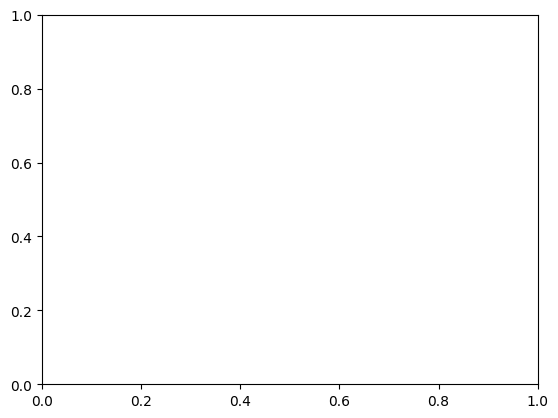

In [21]:
import torch
import matplotlib.pyplot as plt
n_steps = 10
bayesian_counter = 0
finished_bool = False

# test points for plotting
#test_x = torch.linspace(*X.vocs.bounds.flatten(),50).double()

for i in range(n_steps):
    print('step'+str(i))
    t0=time.monotonic()
    X.step()
    t1=time.monotonic()
    print('step'+str(i)+".1: "+str(t1-t0))
    # get the Gaussian process model from the generator
    model = X.generator.model
    t2=time.monotonic()
    print('step'+str(i)+".2: "+str(t2-t0))
    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)
    t3=time.monotonic()
    print('step'+str(i)+".3: "+str(t3-t0))

    

    
#### to plot during
# fig, ax = plt.subplots()
# while bayesian_counter < n_steps and finished_bool == False:
#     bayesian_counter += 1
#     print('step'+str(i))
#     t0=time.monotonic()
#     X.step()
#     t1=time.monotonic()
#     print('step'+str(i)+".1: "+str(t1-t0))
#     # get the Gaussian process model from the generator
#     model = X.generator.model
#     t2=time.monotonic()
#     print('step'+str(i)+".2: "+str(t2-t0))
#     # get acquisition function from generator
#     acq = X.generator.get_acquisition(model)
#     t3=time.monotonic()
#     print('step'+str(i)+".3: "+str(t3-t0))
#     test_inp_str = input('Complete? (y/n)')
#     if test_inp_str == 'y'.lower():
#         finished_bool == True
        
# X.data
# ax.plot(X.data[-1], x=list(InitialPoints_dict)[0], y="f", kind="scatter")
    
    
    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
#     with torch.no_grad():
#         posterior = model.posterior(test_x.unsqueeze(1))
#         acq_val = acq(test_x.reshape(-1,1,1))
#     # get mean function and confidence regions
#     mean = posterior.mean
#     l,u = posterior.mvn.confidence_region()
#     # plot model and acquisition function
#     fig,ax = plt.subplots(2,1,sharex="all")
#     # plot model posterior
#     ax[0].plot(test_x, mean, label="Posterior mean")
#     ax[0].fill_between(test_x, l, u,alpha=0.25, label="Posterior confidence region")
#     # add data to model plot
#     ax[0].plot(X.data["x"],X.data["f"],"C1o", label="Training data")
#     # plot true function
#     true_f = sin_function({"x": test_x})["f"]
#     ax[0].plot(test_x, true_f,'--', label="Ground truth")
#     # add legend
#     ax[0].legend()
#     # plot acquisition function
#     ax[1].plot(test_x, acq_val.flatten())
#     ax[0].set_ylabel("f")
#     ax[1].set_ylabel(r"$\alpha(x)$")
#     ax[1].set_xlabel("x")


<AxesSubplot:xlabel='Position', ylabel='f'>

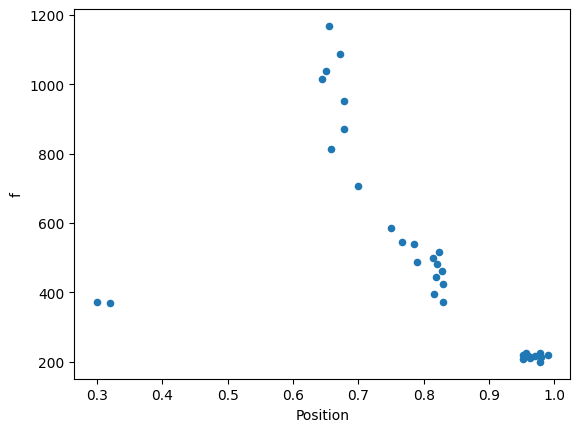

In [25]:
# access the collected data
X.data
X.data.plot(x=list(InitialPoints_dict)[0], y="f", kind="scatter")

## Getting the optimization result
To get the ideal point (without evaluating the point) we ask the generator to
generate a new point.

In [14]:
#X.generator.generate(1)

In [15]:
#manually move to the desired point
#X.evaluate_data(pd.DataFrame({"AxiconHorizontal":[0.867122],"AxiconHorizontal":[0.867122]}))

In [26]:
#to set optimum in one go
X.evaluate_data(X.generator.generate(1))

set Position to 0.6548463761664978
517.8723477099696
517.8723477099696
attempts loop
check value is: 521.019261 and target value is: 517.8723477099696
checking set value
still moving, check value is: 517.872328 and target value is: 517.8723477099696
successfully moved device Position
[1013.0, 1201.0, 1055.0, 929.0, 993.0]


,Position,f,xopt_runtime,xopt_error
34,0.654846,1013.0,3.50075,False


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [17]:
#X.generator.options.dict()

In [18]:
# example: add a Gamma(1.0,10.0) prior to the noise hyperparameter to reduce model noise
# (good for optimizing noise-free simulations)
#X.generator.options.model.kwargs.use_low_noise_prior = True